# Compare SSM and Stan Models

In [1]:
# for now, lets add ../src to sys.path
import sys
sys.path.append('../src')

# import basic stuff
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import zscore

# import the arviz package
import arviz as az

# import CmdStanPy
from cmdstanpy import cmdstan_path, CmdStanModel

# import SSM
import ssm
from ssm.observations import InputDrivenObservations

# import plotnine for plotting
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, stat_summary, geom_errorbar, facet_grid, geom_line, theme, theme_seaborn, theme_538, theme_matplotlib, scale_color_brewer, theme_minimal, theme_light, geom_violin

First, we load the data for one mouse:

In [3]:
mouse_nickname = "CSHL_015" # nickname of the mouse

# load the data into a dataframe
df = pd.read_csv("../data/preprocessed-trials.csv", na_values="NA")

# filter for nickname
df = df[df["subject_nickname"] == mouse_nickname] #CSHL_015 KS019

df["stim_contrast_minus_1"] = np.sign(df["stim_contrast"].shift(1).fillna(0))
df["response_cw_minus_1"] = df["response_cw"].shift(1).fillna(0).astype(int)
df["intercept"] = 1

T = [len(d) for _,d in df.groupby("session_start_time")]

df[["stim_contrast", "stim_contrast_minus_1", "response_cw_minus_1"]] = df[["stim_contrast", "stim_contrast_minus_1", "response_cw_minus_1"]].apply(zscore)


x = df[["intercept", "stim_contrast", "stim_contrast_minus_1", "response_cw_minus_1"]].values
x_sessions = [d[["intercept", "stim_contrast", "stim_contrast_minus_1", "response_cw_minus_1"]].values for _,d in df.groupby("session_start_time")]

y = 1-df["response_cw"].values.astype(int)
y_sessions = [d[["response_cw"]].values.astype(int).reshape(-1, 1) for _,d in df.groupby("session_start_time")]

## The Model


### Fitting the Model with SSM
Then, we fit the model with the SSM library.

In [51]:
ssm_model  = ssm.HMM(2, 1, 2, 
                observations=InputDrivenObservations(K=2, D=1, M=4, prior_mean = 0, prior_sigma = 2), 
                transitions="sticky", transition_kwargs=dict(alpha=np.array([1,10]), kappa=0))
_ = ssm_model.fit(y_sessions, inputs=x_sessions,
                method="em", num_iters=1000, tolerance=10**-4, )

Converged to LP: -3091.9:   4%|▍         | 41/1000 [00:01<00:43, 22.16it/s]


### Fitting the Model with Stan

We can now implement the same model using Stan. Here, I used CmdStanPy to interface with the Stan library. The actual model is specified in the file `stan-models/glm-hmm.stan` and CmdStanPy takes care of compiling the model and running the sampler. Note that because we not currently dealing with label-switching, we can only run one chain (within-chain label-switching does not seem to be a problem). See [this case study by Micheal Betancourt](https://betanalpha.github.io/assets/case_studies/identifying_mixture_models.html). for more details.

We then make use of the `arviz` package. Arviz is a python package for analyzing Bayesian (sampling) data. It implements a variety of diagnostics and plots for Bayesian models. When importing fromt CmdStanPy, we can also tell `arviz` to label the dimensions in our data to make it easier to work with.

In [58]:
# load the model code and compile it
stan_model = CmdStanModel(stan_file = "../stan-models/glm-hmm.stan")

# define the input data for the model
stan_data =  {
    "T": T,             # length of each sequence
    "N": len(T),        # number of sequences
    "I": np.sum(T),     # number of (flattend/total) obervations
    "M": 4,             # number of predictors for observations
    "K": 2,             # number of hidden states
    "R": 1,             # dimensionality of observations
    "x": x,             # predictors for obervation model
    "y": np.squeeze(y)  # observations
  }

# fit the model(=sample from the posterior)
stan_model_fit = stan_model.sample(data=stan_data, chains=1, iter_sampling = 1000, iter_warmup=1000, refresh=5, show_progress="notebook")

# convert to arviz datastructure 
stan_model_fit_az = az.from_cmdstanpy(
    posterior=stan_model_fit,
    observed_data={"y": stan_data["y"]}, 
    save_warmup=False,
    coords = {"State": ["state 1","state 2"], "Coefficient": ["intercept", "stim contrast", "stim contrast minus 1", "response cw minus 1"]},
    dims = {"betas_x": ["State", "Coefficient"]}
)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/marcpabst/Documents/Repositories/bayesian-mice-decisions/stan-models/glm-hmm


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

## Plotting the Data
### Convert Data to DataFrames

I will use `plotnine` for plotting, because it implements the "grammar of graphics" and has an interface that is very close to that of `ggplot2` in `R`. To use `plotnine`, we first need to convert the data into `pandas` dataframes.

In [80]:
# for the ssm data ...
# sorry this is a bit of a mess, but it's a lot easier to work with the data in this format
# I also align the states manually, because it's nice for comparison

ssm_df = pd.DataFrame()

for state, state_name in zip([1,0], ["state 1", "state 2"]):
    state_data = ssm_model.observations.params[state]
    for coeff, coeff_name in enumerate(["intercept", "stim contrast", "stim contrast minus 1", "response cw minus 1"]):
        ssm_df = ssm_df.append({"State": state_name, "Coefficient": coeff_name, "value": state_data[0, coeff]}, ignore_index=True)
ssm_df["Source"] = "SSM"

# ... and for the stan data
draws = stan_model_fit_az.posterior.betas_x.to_dataframe().reset_index()
draws["Source"] = "Stan"

### Plotting the Data

We now plot
- *Stan:* the mean of the posterior distribution of the parameters
- *Stan:* the 89% crediible interval (HDI = highest density interval) of the posterior
- *SSM:* the point estimate (MAP) for the parameters (techically, this should correspond to the **mode** of the posterior distribution)

Note for interpreting credible intervals: The 89%-HDI can be interpreted the way many people (incorrectly) interpret the 89% confidence interval. That is, there is a 89% probability that the true parameter value lies within the HDI. Why 89%? “Because it is prime.” To quote McElreath (2020):

> But I don’t recommend 95% intervals, because readers will have a hard time not viewing them as significance tests. 89 is also a prime number, so if someone asks you to justify it, you can stare at them meaningfully and incant, “Because it is prime.” That’s no worse justification than the conventional justification for 95%.

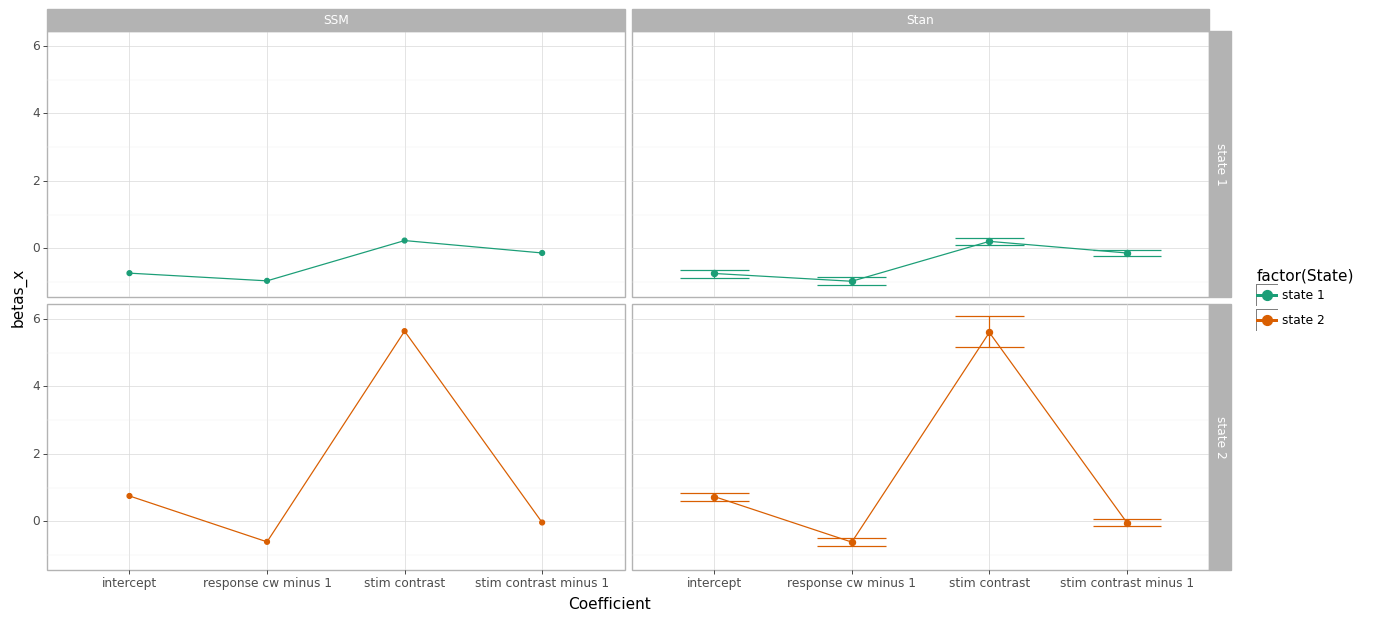

<ggplot: (344557797)>

In [81]:
def stat_hdi(series):
    data = series.values
    min, max = az.hdi(data, hdi_prob=0.89)
    return pd.DataFrame({"ymin": [min], "ymax": [max]})

(ggplot(draws, aes('Coefficient', 'betas_x', color='factor(State)'))
 + facet_grid('State ~ Source')
 + stat_summary()
 + stat_summary(geom = "geom_errorbar", fun_data = stat_hdi)
 + stat_summary(geom = "geom_line",  group="state")
 # now the same for the ssm data (only points)
 + geom_point(data=ssm_df, mapping=aes("Coefficient", "value"), group="State")
 + geom_line(data=ssm_df, mapping=aes("Coefficient", "value"), group="State")
 + theme_light()
 + scale_color_brewer(type='qual', palette=2)
 + theme(figure_size = (15, 7))
 )

## More Plotting
We can use the `arviz` package to plot lots of interesting things. Idealy, we would also run and plot a number of different diagnostics like $\hat R$, prior and posterior predictive checks etc. For now, we will just plot the posterior distributions.

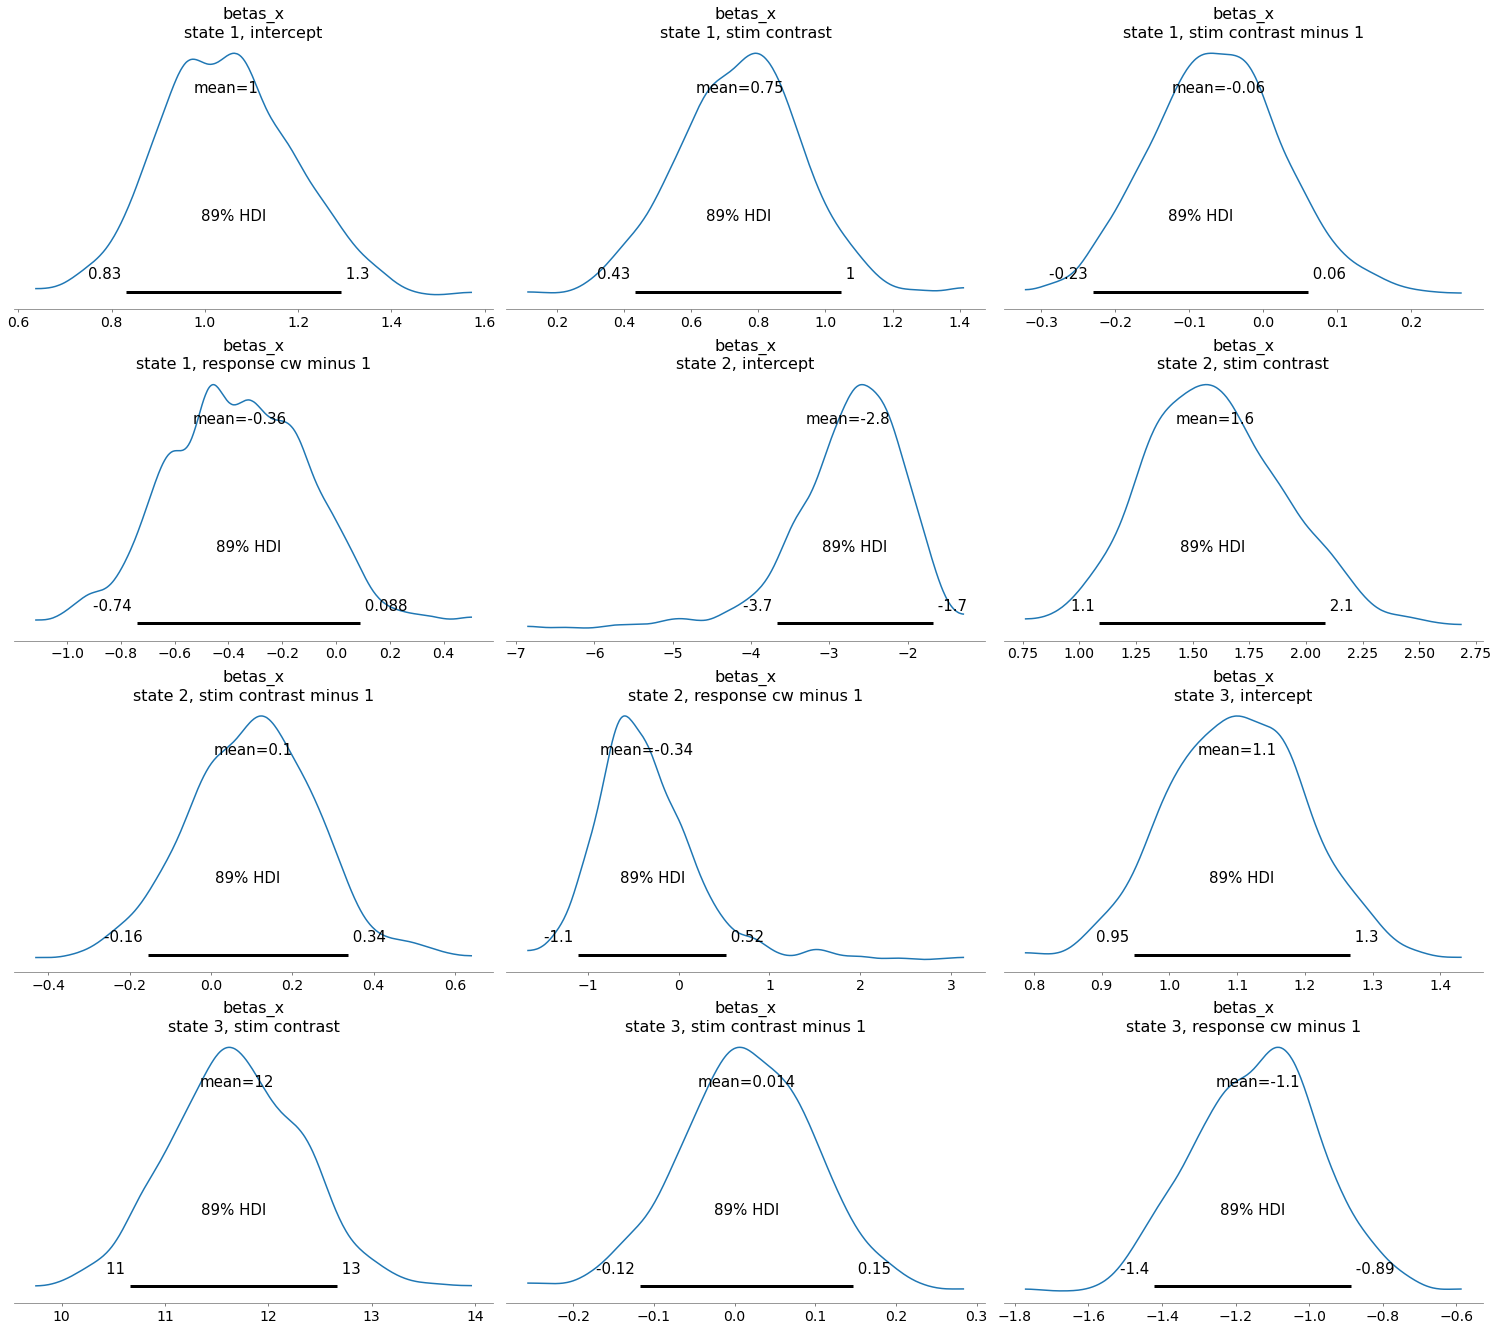

In [135]:
_ = az.plot_posterior(stan_model_fit_az, var_names=["betas_x"], hdi_prob=.89)

In [11]:
from scipy.optimize import linear_sum_assignment
def find_best_assigments(sets, num_el, ref=0):
    ref_set = sets[ref]
    perms = [np.array(range(num_el))]
    for set in sets:
        if set is not ref_set:
            cost_matrix = np.zeros((num_el,num_el))
            for i, a_row in enumerate(ref_set):
                for j, b_row in enumerate(set):
                    cost_matrix[i,j] = np.linalg.norm(a_row - b_row)
            perms.append(linear_sum_assignment(cost_matrix)[1])
    return perms

In [13]:
sets = []

for chain in range(4):
    chain_data = stan_model_fit_az.sel(chain=[chain]).posterior.mean(dim=['chain', 'draw']).betas_x.values
    sets.append([a for a in chain_data])

best_assignments = find_best_assigments(sets, 3)

best_assignments

[array([0, 1, 2]), array([2, 0, 1]), array([1, 2, 0]), array([2, 1, 0])]

In [14]:
import xarray as xr
chains = []


for i, chain_data in stan_model_fit_az.posterior.groupby("chain"):
    chains.append(chain_data.assign_coords({"States": best_assignments[i]}))
    chains[i].sortby("States")

post = xr.concat(chains, dim='chain')

In [65]:
stan_model_fit_az.sel(chain=[0,1,2,3]).posterior.mean(dim=['draw'])

<xarray.Dataset>
Dimensions:              (chain: 4, pi_dim_0: 3, State: 3, Coefficient: 4, A_dim_0: 3, A_dim_1: 3, logpi_dim_0: 3, log_like_sess_dim_0: 69)
Coordinates:
  * chain                (chain) int64 0 1 2 3
  * pi_dim_0             (pi_dim_0) int64 0 1 2
  * State                (State) int64 0 1 2
  * Coefficient          (Coefficient) <U21 'intercept' ... 'response cw minu...
  * A_dim_0              (A_dim_0) int64 0 1 2
  * A_dim_1              (A_dim_1) int64 0 1 2
  * logpi_dim_0          (logpi_dim_0) int64 0 1 2
  * log_like_sess_dim_0  (log_like_sess_dim_0) int64 0 1 2 3 4 ... 65 66 67 68
Data variables:
    pi                   (chain, pi_dim_0) float64 0.08625 0.5683 ... 0.1975
    betas_x              (chain, State, Coefficient) float64 5.169 ... -0.2645
    A                    (chain, A_dim_0, A_dim_1) float64 0.8731 ... 0.929
    logpi                (chain, logpi_dim_0) float64 -2.701 -0.5748 ... -1.67
    log_like_sess        (chain, log_like_sess_dim_0) float64 -75.67 ... -44.3

In [90]:
stan_model_fit_az.posterior.betas_x.sel().values.mean(1)

array([[[  1.31977208,   6.32890846,   0.03850893,  -1.11730668],
        [ -2.79288141,   0.90221563,   0.01748811,  -0.32569597],
        [  1.04816307,   0.39462749,  -0.05648597,  -0.36934998]],

       [[  5.2729072 ,   0.59274892,  -0.12040399, -12.74975723],
        [  1.26930391,   6.27600076,   0.01564737,  -1.17153237],
        [ -0.46631441,   0.44283262,  -0.05950596,   0.19111603]],

       [[  1.31340222,   6.33395618,   0.04174906,  -1.11081116],
        [  1.05767447,   0.40110511,  -0.05562524,  -0.36627878],
        [ -2.76712526,   0.88909797,   0.02211841,  -0.32192867]],

       [[  1.31633168,   6.3399853 ,   0.03839587,  -1.11587249],
        [ -2.80997691,   0.88394067,   0.02753042,  -0.28045929],
        [  1.05492892,   0.39828965,  -0.05371905,  -0.36303868]]])

/Users/marcpabst/miniforge3/lib/python3.9/site-packages/arviz/plots/pairplot.py:229: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
/Users/marcpabst/miniforge3/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:239: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid


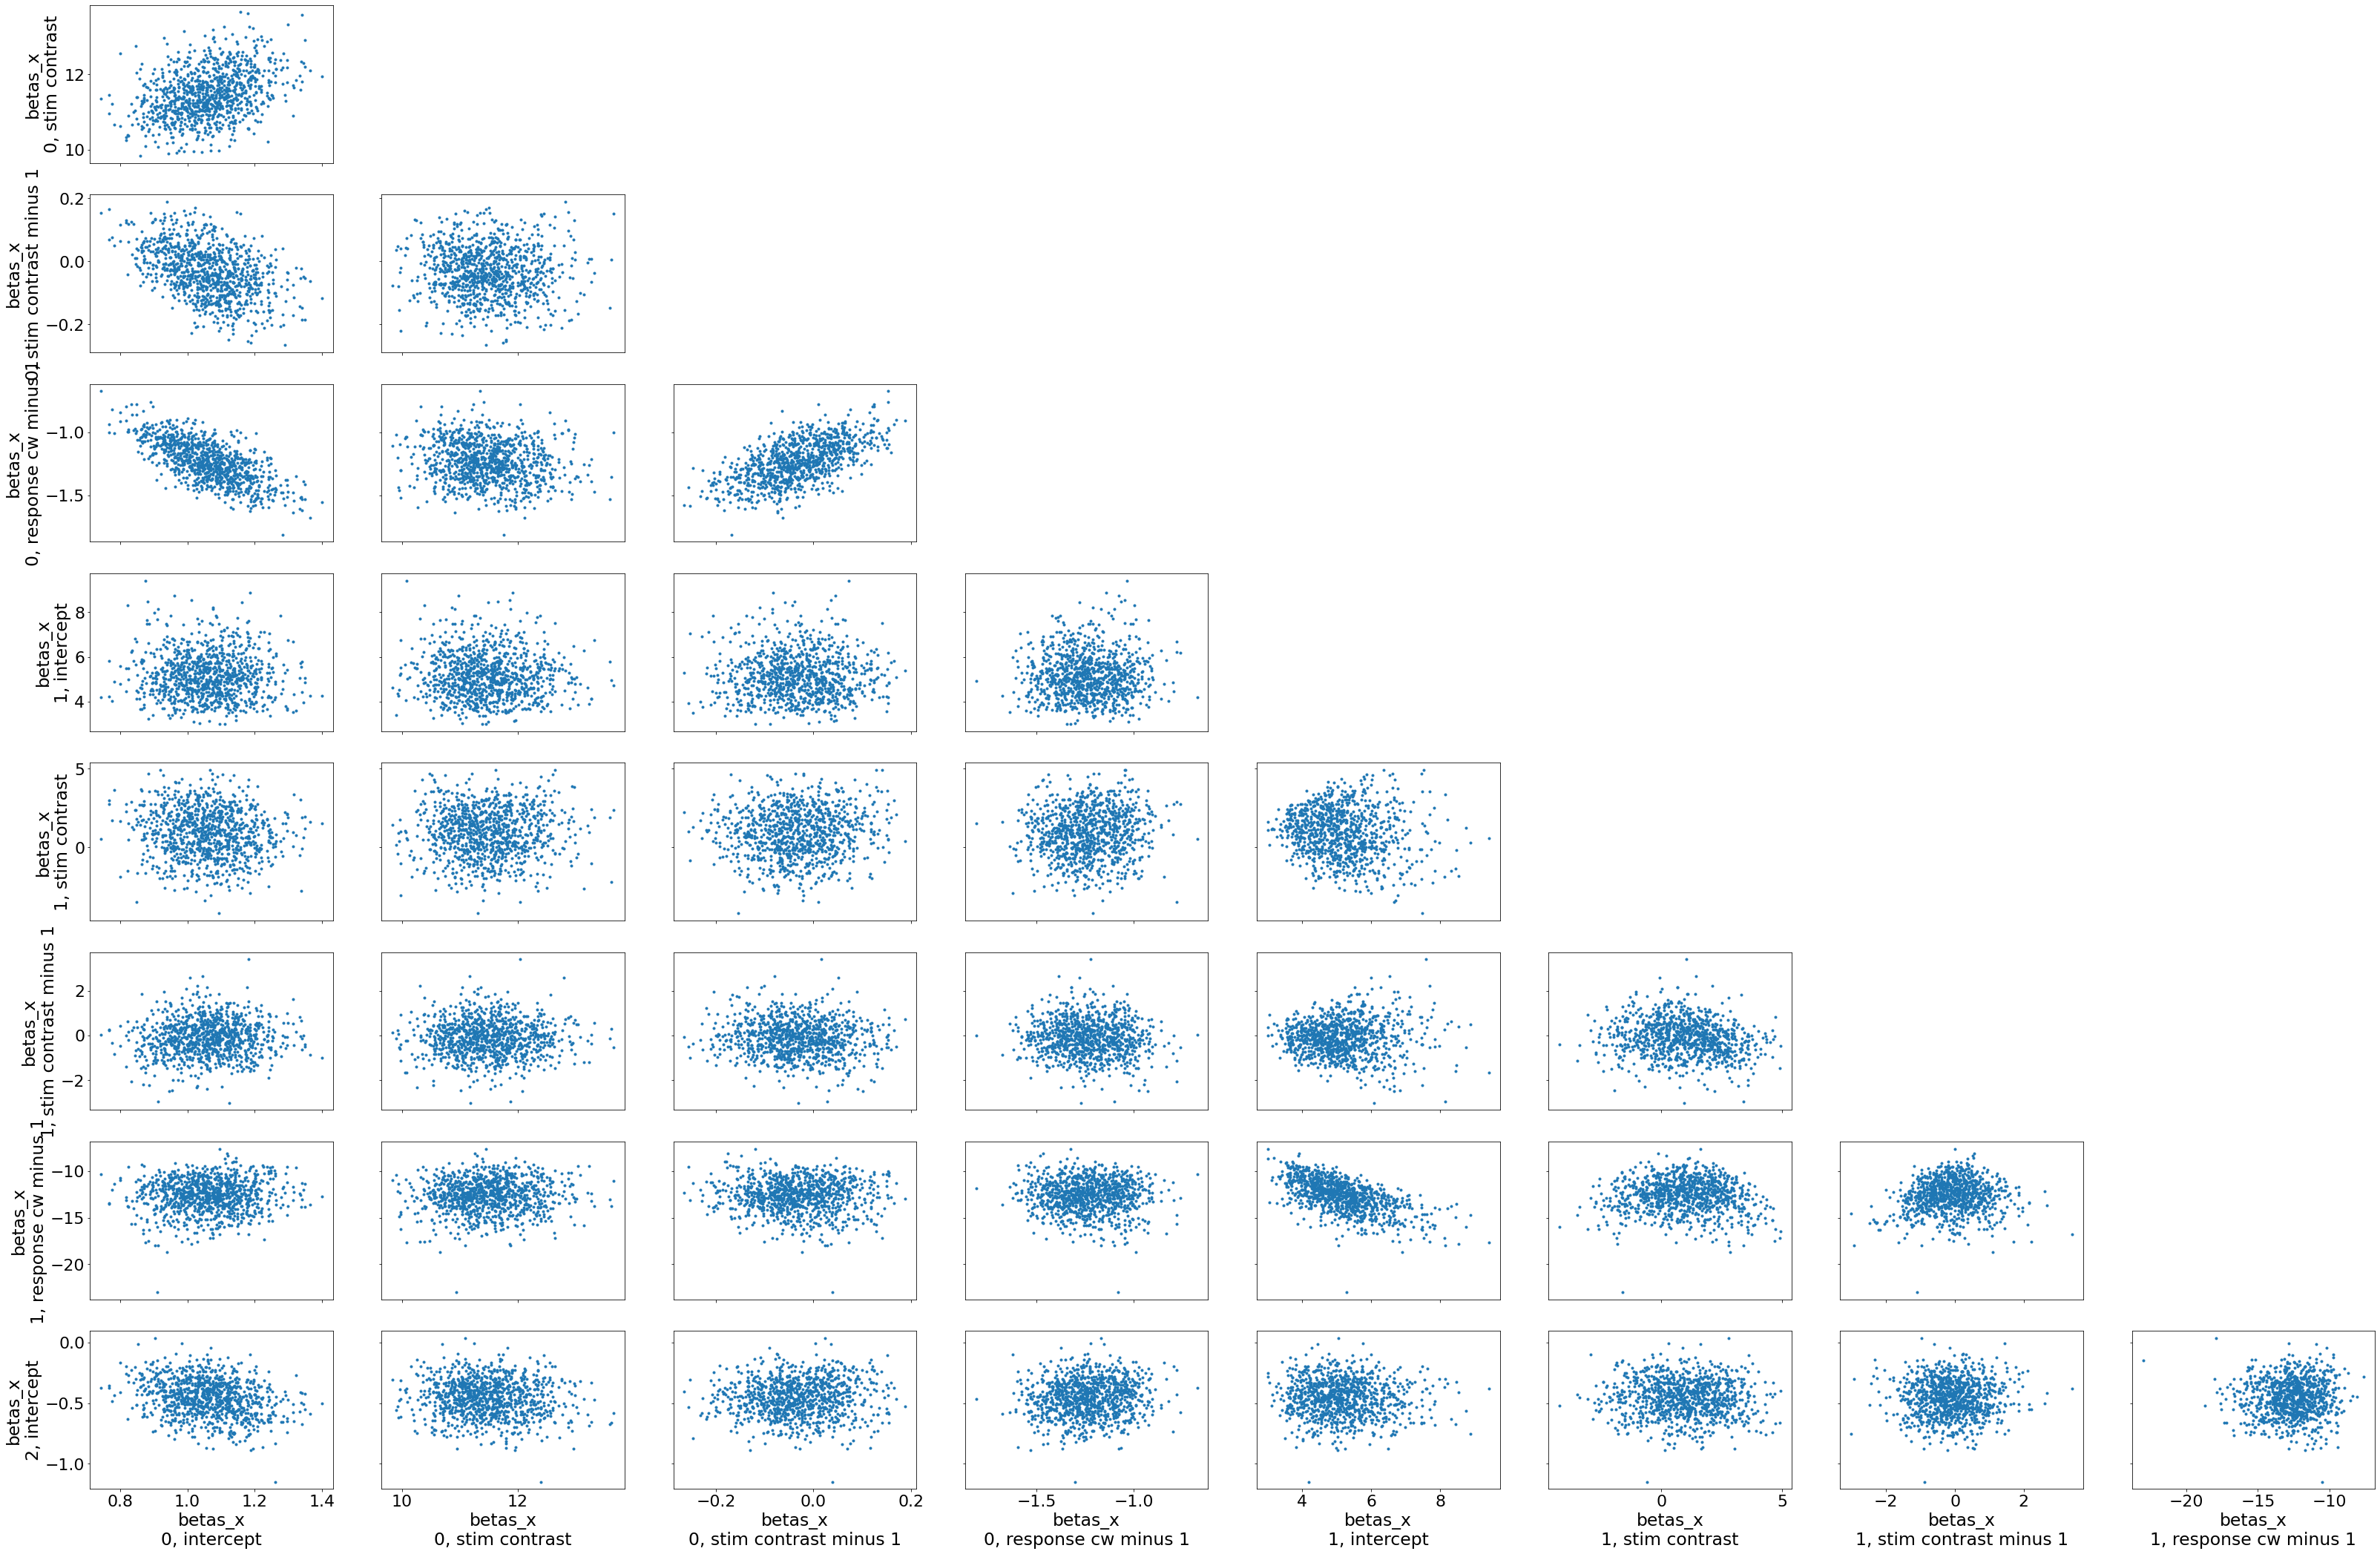

In [59]:
_ = az.plot_pair(stan_model_fit_az.posterior.sel(chain=[1]), var_names=["betas_x"], divergences=True, textsize=22)

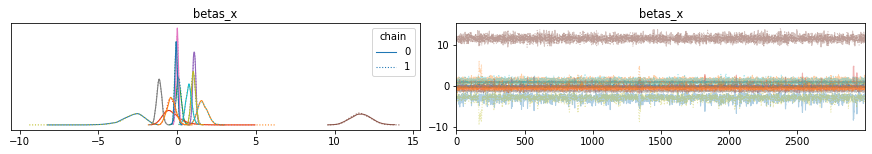

In [78]:
_ = az.plot_trace(stan_model_fit_az.posterior.sel(chain=[1,3]), var_names=["betas_x"], legend=True)

In [82]:
import math, datetime
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

mtcars = data(datasets).fetch('mtcars')['mtcars']

MemoryError: Cannot allocate write+execute memory for ffi.callback(). You might be running on a system that prevents this. For more information, see https://cffi.readthedocs.io/en/latest/using.html#callbacks